# 2-Point Correlation Function (2PCF) analysis 

In this notebook we perform the main analysis using 2PCFs in pregnant women at ANC visits and comparing parasitological with serological data. 

Main analysis:

1- 2PCF measurements: 2PCF statistics will be obtained for the three years data separately, cross-correlating PCR data with serological data for the different antigens using all pregnant women at first ANC.

2- Consistency analysis: a t-test will be used to measure the statistical significance of the clustering signal of the different populations by measuring the deviation of the 2PCFs from zero. A table will be created describing the p-values of each population and year to identify the most significant clustering structures found. 

## Importing modules and functions

In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from spatial_tools import clustering, visualise
from stat_tools import errors
import contextily as ctx
from pregmal_pytools import spatial_utils
from stat_tools import stats

In [2]:
import imp
imp.reload(spatial_utils)

<module 'pregmal_pytools.spatial_utils' from '/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/pregmal_pytools-1.0-py3.8.egg/pregmal_pytools/spatial_utils.py'>

## Importing data 

In [3]:
mipmon, cross, cross210, antigens = spatial_utils.import_spatial_data()

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/pregmal_pytools-1.0-py3.8.egg/pregmal_pytools/spatial_utils.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross['pospcr'][cross['pospcr'] == 'Negative'] = 0.
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/pregmal_pytools-1.0-py3.8.egg/pregmal_pytools/spatial_ut

In [4]:
mipmon = mipmon.rename(columns = {
                        'FMM_DBL34' : 'FMM_DBL3-4'
                        }
                      )

In [5]:
antigens[-3] = 'DBL3-4'
antigens

['MSP1',
 'HSP40',
 'Etramp',
 'ACS5',
 'EBA175',
 'PfTramp',
 'GEXP18',
 'PfRH2',
 'PfRH5',
 'P1',
 'P39',
 'P8',
 'PD',
 'DBL3-4',
 'All peptides',
 'P1+P8']

## Define masks and other definitions

In [6]:
#MiPMon masks
has_geo_mip = mipmon['latitude'].notnull()&mipmon['longitude'].notnull()
has_pcr_mip = mipmon['pcrpos'].notnull()&has_geo_mip
mip_pcrpos = mipmon['pcrpos'] == 1
mip_pcrneg = mipmon['pcrpos'] == 0
mip_rdtpos = mipmon['density'] >= 100
mip_rdtneg = mipmon['density'] < 100
prenatal = (mipmon['visit'] == 'PN')&has_pcr_mip

#Define masks for MiPMon data
mipmon_pn = prenatal&has_pcr_mip
mipmon_pg = mipmon_pn&(mipmon['gestnum'] == 1)
mipmon_sg = mipmon_pn&(mipmon['gestnum'] == 2)
mipmon_12g = mipmon_pn&(mipmon['gestnum'] <= 2)
mipmon_mg = mipmon_pn&(mipmon['gestnum'] > 1)
mipmon_3g = mipmon_pn&(mipmon['gestnum'] > 2)
mipmon_hiv_pos = mipmon_pn&(mipmon['hiv'] == 'HIV+')
mipmon_hiv_neg = mipmon_pn&(mipmon['hiv'] == 'HIV-')
mipmon_pg_hiv_pos = mipmon_pg&mipmon_hiv_pos
mipmon_pg_hiv_neg = mipmon_pg&mipmon_hiv_neg

mipmon_selection = {
    'All ANC visits' : mipmon_pn,
    'Primigravidae' : mipmon_pg,
    #'Secundigravid' : mipmon_sg,
    #'1-2gravid' : mipmon_12g,
    #'>2gravid' : mipmon_3g,
    'Multigravidae' : mipmon_mg,
    'HIV+' : mipmon_hiv_pos,
    'HIV-' : mipmon_hiv_neg,
    #'PG HIV+' : mipmon_pg_hiv_pos,
    'Primigravid HIV-' : mipmon_pg_hiv_neg,
}

#Cross masks
cross210_area_mask = (cross210['area'] == 'Magude Sede')|(cross210['area'] == 'Manhiça')|(cross210['area'] == 'Ilha Josina')
cross210_area_mask = cross210_area_mask | (cross210['area'] == 'Taninga')|(cross210['area'] == 'Panjane')
cross210_area_mask = cross210_area_mask |(cross210['area'] == 'Palmeira')
cross210_area_mask = cross210_area_mask | (cross210['area'] == 'Maragra')|(cross210['area'] == 'Malavele')
has_geo_cross = cross['lat'].notnull()&cross['lng'].notnull()
has_pcr_cross = cross['pospcr'].notnull()&has_geo_cross
has_rdt_cross = cross['rdt'].notnull()&has_geo_cross
cross_pcrpos = cross['pospcr'] == 1
cross_pcrneg = cross['pospcr'] == 0
cross_rdtpos = cross['rdt'] == 1
cross_rdtneg = cross['rdt'] == 0

has_geo_cross210 = cross210['lat'].notnull()&cross210['lng'].notnull()
has_pcr_cross210 = cross210['pospcr'].notnull()&has_geo_cross210
has_rdt_cross210 = cross210['rdt'].notnull()&has_geo_cross210
cross210_pcrpos = cross210['pospcr'] == 1
cross210_pcrneg = cross210['pospcr'] == 0
cross210_rdtpos = cross210['rdt'] == 1
cross210_rdtneg = cross210['rdt'] == 0


#Colour palette for MiPMon selections
colors_mipmon = [cm.turbo((i+1)/float(len(antigens) + 1)) for i in range(len(antigens) + 1)]

#years = [2017, 2018, 2019]
years = [1, 2, 3]

# Analysis 

###Chosen 2PCF parameters 

In [7]:
#Number of spatial bins
bins = 10
bins_small_scale = 6
#Spatial range of scale in Km
ranges = [.0,60.]
range_small_scale = [0, 15]
#Number of random realisations
nrands = 20


### 2PCF measurements 
 

In [8]:
def get_2pcf_cross(dataframe, pcrpos, mask, bins, ranges, nrands, colour, \
                   get_error = True, show = True, lw = 2):
    #Defining input data from cross-sectional 2PCFs
    x1 = np.array(dataframe[mask&pcrpos]['lng'])
    y1 = np.array(dataframe[mask&pcrpos]['lat'])
    x2 = np.array(dataframe[mask]['lng'])
    y2 = np.array(dataframe[mask]['lat'])
    w1 = np.array(dataframe[mask&pcrpos]['weight'])
    w2 = np.array(dataframe[mask]['weight'])
    
    #Run 2PCF for cross-sectional
    cross_2pcf, mean_bin_cross, edges, cross_err = clustering.correlation_function(x1, y1, x2, y2, \
                                                                                bins = bins, \
                                                                                ranges = ranges, \
                                                                                get_error=get_error, \
                                                                                nrands = nrands, \
                                                                                w1 = w1, w2 = w2)
    #Plotting results for non-empty data
    mask_empty_bins = (cross_2pcf**2>=0)&(cross_err**2>=0)
    if show:
        plt.errorbar(mean_bin_cross[mask_empty_bins], cross_2pcf[mask_empty_bins], \
                     cross_err[mask_empty_bins], c = 'k', label = "Children 2-10", \
                    linestyle = '--', lw = lw)
    return cross_2pcf, mean_bin_cross, edges, cross_err

def get_2pcf_pcr(dataframe, pcrpos, mask, bins, ranges, nrands, colour, \
                 get_error = True, show = True, lw = 2):
    #Defining input data from cross-sectional 2PCFs
    x1 = np.array(dataframe[mask&pcrpos]['longitude'])
    y1 = np.array(dataframe[mask&pcrpos]['latitude'])
    x2 = np.array(dataframe[mask]['longitude'])
    y2 = np.array(dataframe[mask]['latitude'])
    w1 = None
    w2 = None
    
    #Run 2PCF for cross-sectional
    cross_2pcf, mean_bin_cross, edges, cross_err = clustering.correlation_function(x1, y1, x2, y2, \
                                                                                bins = bins, \
                                                                                ranges = ranges, \
                                                                                get_error=get_error, \
                                                                                nrands = nrands, \
                                                                                w1 = w1, w2 = w2)
    #Plotting results for non-empty data
    mask_empty_bins = (cross_2pcf**2>=0)&(cross_err**2>=0)
    if show:
        plt.errorbar(mean_bin_cross[mask_empty_bins], cross_2pcf[mask_empty_bins], \
                     cross_err[mask_empty_bins], c = 'k', label = "qPCR data", linestyle = '--', \
                    lw = lw)
    return cross_2pcf, mean_bin_cross, edges, cross_err

def get_2pcf_mipmon(dataframe, pcrpos, antigen, mask, bins, ranges, nrands, \
                    colour, get_error = True, show = True, label = '', mode = 'auto', lw = 2):#TODO define mode {'auto', 'cross'}
    #Defining input data from ANC 2PCFs
    #TODO make this cross between pcrpos and antigens
    x1 = np.array(dataframe[mask&antigen]['longitude'])
    y1 = np.array(dataframe[mask&antigen]['latitude'])
    x2 = np.array(dataframe[mask]['longitude'])
    y2 = np.array(dataframe[mask]['latitude'])
    w1 = None
    w2 = None
    #TODO define x1x, y1x, as [mask&antigen] if mode == 'cross', as None if mode == 'auto'
    if mode == 'cross':
        x1x = np.array(dataframe[mask&pcrpos]['longitude'])
        y1x = np.array(dataframe[mask&pcrpos]['latitude'])
    elif mode == 'auto':
        x1x, y1x = None, None
    else:
        print("WARNING: invalid value of mode", mode, ", assuming auto")
        x1x, y1x = None, None
    
    #Run 2PCF for ANC
    #TODO make this cross between pcrpos and antigens
    mip_2pcf, mean_bin_mip, edges, \
    mip_err = clustering.correlation_function(x1, y1, x2, y2, \
                                              bins = bins, ranges = ranges, \
                                              get_error=get_error, \
                                              nrands = nrands, \
                                              w1 = w1, w2 = w2, x1x = x1x, y1x = y1x)#TODO TEST
    #Plotting results for non-empty data
    mask_empty_bins = (mip_2pcf**2>=0)&(mip_err**2>=0)
    if show:
        plt.errorbar(mean_bin_mip[mask_empty_bins], mip_2pcf[mask_empty_bins], \
                     mip_err[mask_empty_bins], c = colour, label = label, lw = lw)
    return mip_2pcf, mean_bin_mip, edges, mip_err

def get_2pcf_antigens(dataframe, pcrpos, antigens, mask, bins, ranges, nrands, \
                               colours, get_error = True, show = True, mode = 'auto', lw = 2):#TODO define mode {'auto', 'cross'}
    mip_2pcf, mean_bin_mip, edges, mip_err = {}, {}, {}, {}
    for c, s in enumerate(antigens):
        #Run 2PCF for ANC
        mip_2pcf[s], mean_bin_mip[s], edges[s], \
        mip_err[s] = get_2pcf_mipmon(dataframe, pcrpos, np.array(dataframe[s]) == 1, mask, \
                                             bins, ranges, get_error=get_error, nrands = nrands, \
                                             colour = colours[c], label = s[4:], mode = mode, lw = lw)#TODO TEST
    return mip_2pcf, mean_bin_mip, edges, mip_err

def get_all_2pcf_years(mipmon_df, mip_pcrpos, antigens, mip_mask, cross_df, cross_pcrpos, cross_mask, bins, \
                       ranges, nrands, colors_mipmon, colour_cross, get_error = True, show = True, verbose = False, \
                       time_width = None, figsize = None, mode = 'auto', ylims = None, ncol = 2, lw = 2, \
                      cross_pop = 'mipmon'):
    #Dictionary to store results from ANC data
    mip_2pcf, mean_bin_mip, edges, mip_err = {}, {}, {}, {}
    cross_2pcf, mean_bin_cross, edges, cross_err  = {}, {}, {}, {}
    
    for y in years:
        plt.figure(figsize = figsize)
        #Mask to select the year of the data
        cross_mask_time, mip_mask_time = get_time_masks(cross_df, mipmon_df, y, time_width = time_width)
        
        #Run 2PCF for all ANC selections
        if verbose:
            print('Sample size serological data:', np.sum(mip_mask_time&mip_mask))
        mip_2pcf[str(y)], mean_bin_mip[str(y)], edges[str(y)], mip_err[str(y)] = \
        get_2pcf_antigens(mipmon_df, mip_pcrpos, antigens, mip_mask_time&mip_mask, \
                          bins, ranges, nrands, colors_mipmon, get_error = get_error, \
                          show = show, mode = mode, lw = lw)#TODO TEST
        
        
        
        #Run 2PCF for cross-sectional
        if verbose:
            print('Sample size PCR data:', np.sum(cross_mask_time&cross_mask))
        if cross_pop == 'mipmon':
            cross_2pcf[str(y)], mean_bin_cross[str(y)], edges[str(y)], cross_err[str(y)] = \
            get_2pcf_pcr(cross_df, cross_pcrpos, cross_mask_time&cross_mask, bins, \
                         ranges, nrands, colour_cross, get_error = get_error, show = show, \
                        lw = lw)
        elif cross_pop == 'cross':
            get_2pcf_cross(cross_df, cross_pcrpos, cross_mask_time&cross_mask, bins, \
                         ranges, nrands, colour_cross, get_error = get_error, show = show, \
                        lw = lw)
        
        
        plt.hlines(0, ranges[0] - 2, ranges[1] + 2, color = 'tab:grey')
        plt.xlim(ranges[0] - 2, ranges[1] + 2)
        #plt.legend(ncol = ncol)
        plt.xlabel('r (Km)')
        plt.ylabel(r'$\xi(r)$ year '+ str(y))
        #plt.title("2PCF year "+ str(y))
        plt.ylim(ylims)
        plt.show()
    return mip_2pcf, mean_bin_mip, edges, mip_err, cross_2pcf, mean_bin_cross, edges, cross_err

def get_time_masks(cross_df, mipmon_df, year, time_width = None, verbose = False):
    #Mask to select the year of the data
    cross_mask = cross_df['year'] == year
    if verbose:
        print('Sample size cross-sectional:', np.sum(cross_mask))
    if time_width is None:
        mip_mask = mipmon_df['year'] == year
    else:
        mean_cross_data = cross_df['visdate'][cross_mask].mean()
        mip_mask = get_time_mask_mipmon(mipmon_df, mean_cross_data, time_width, verbose = verbose)
    return cross_mask, mip_mask

def get_time_mask_mipmon(mipmon_df, date, time_width, verbose = True):
    #Selection a window aroung the cross-sectional data for ANC
    time_0 = date - pd.to_timedelta(time_width/2, unit = 'D')
    time_1 = date + pd.to_timedelta(time_width/2, unit = 'D')
    mip_mask = (mipmon_df['visdate'] >= time_0)&(mipmon_df['visdate'] <= time_1)
    if verbose:
        print('Sample size all 1st ANC:', np.sum(mip_mask))
    return mip_mask

In [9]:
def get_2pcf_mipmon_cross(dataframe, pcrpos, mask, bins, ranges, nrands, colour, \
                    get_error = True, show = True, label = '', mode = 'auto', \
                    cross_df = None, cross_pcrpos = None, cross_mask = None, \
                   lw = 2):
    #Defining input data from ANC 2PCFs
    x1 = np.array(dataframe[mask&pcrpos]['longitude'])
    y1 = np.array(dataframe[mask&pcrpos]['latitude'])
    x2 = np.array(dataframe[mask]['longitude'])
    y2 = np.array(dataframe[mask]['latitude'])
    w1 = None
    w2 = None
    if mode == 'cross':
        x1x = np.array(cross_df[cross_mask&cross_pcrpos]['lng'])
        y1x = np.array(cross_df[cross_mask&cross_pcrpos]['lat'])
        x2x = np.array(cross_df[cross_mask]['lng'])
        y2x = np.array(cross_df[cross_mask]['lat'])
        w1x = np.array(cross_df[cross_mask&cross_pcrpos]['weight'])
        w2x = np.array(cross_df[cross_mask]['weight'])
    elif mode == 'auto':
        x1x, y1x, x2x, y2x, w1x, w2x = None, None, None, None, None, None
    else:
        print("WARNING: invalid value of mode", mode, ", assuming auto")
        x1x, y1x, x2x, y2x, w1x, w2x = None, None, None, None, None, None
    
    #Run 2PCF for ANC
    mip_2pcf, mean_bin_mip, edges, \
    mip_err = clustering.correlation_function(x1, y1, x2, y2, \
                                              bins = bins, ranges = ranges, \
                                              get_error=get_error, \
                                              nrands = nrands, \
                                              w1 = w1, w2 = w2, \
                                              x1x = x1x, y1x = y1x, \
                                              x2x = x2x, y2x = y2x, w1x = w1x, w2x = w2x)
    #Plotting results for non-empty data
    mask_empty_bins = (mip_2pcf**2>=0)&(mip_err**2>=0)
    if show:
        plt.errorbar(mean_bin_mip[mask_empty_bins], mip_2pcf[mask_empty_bins], \
                     mip_err[mask_empty_bins], c = colour, label = label, lw = lw)
    return mip_2pcf, mean_bin_mip, edges, mip_err

def get_2pcf_antigens_cross(dataframe, pcrpos, antigens, mask, bins, ranges, nrands, \
                               colours, get_error = True, show = True, mode = 'auto', \
                               cross_df = None, cross_pcrpos = None, cross_mask = None, \
                            lw = 2):#TODO define mode {'auto', 'cross'}
    mip_2pcf, mean_bin_mip, edges, mip_err = {}, {}, {}, {}
    for c, s in enumerate(antigens):
        #Run 2PCF for ANC
        mip_2pcf[s], mean_bin_mip[s], edges[s], \
        mip_err[s] = get_2pcf_mipmon_cross(dataframe, pcrpos, np.array(dataframe[s]) == 1, \
                                             bins, ranges, nrands = nrands, colour = colours[c], \
                                             get_error=get_error, label = s[4:], mode = mode, \
                                    cross_df = cross_df, cross_pcrpos = cross_pcrpos, \
                                     cross_mask = cross_mask, lw = lw)#TODO TEST
    return mip_2pcf, mean_bin_mip, edges, mip_err

def get_all_2pcf_years_sero_cross(mipmon_df, mip_pcrpos, antigens, mip_mask, cross_df, cross_pcrpos, cross_mask, bins, \
                       ranges, nrands, colors_mipmon, colour_cross, get_error = True, show = True, verbose = False, \
                       time_width = None, figsize = None, mode = 'auto', ylims = None, ncol = 2, lw = 2, \
                                 fontsize = None, legend = True):
    #Dictionary to store results from ANC data
    mip_2pcf, mean_bin_mip, edges, mip_err = {}, {}, {}, {}
    cross_2pcf, mean_bin_cross, edges, cross_err  = {}, {}, {}, {}
    
    for y in years:
        plt.figure(figsize = figsize)
        #Mask to select the year of the data
        cross_mask_time, mip_mask_time = get_time_masks(cross_df, mipmon_df, y, time_width = time_width)
        
        #Run 2PCF for all ANC selections
        if verbose:
            print('Sample size serological data:', np.sum(mip_mask_time&mip_mask))
        mip_2pcf[str(y)], mean_bin_mip[str(y)], edges[str(y)], mip_err[str(y)] = \
        get_2pcf_antigens_cross(mipmon_df, mip_pcrpos, antigens, mip_mask_time&mip_mask, \
                          bins, ranges, nrands, colors_mipmon, get_error = get_error, \
                          show = show, mode = mode, cross_df = cross_df, \
                                   cross_pcrpos = cross_pcrpos, \
                                   cross_mask = cross_mask_time&cross_mask, lw = lw)#TODO TEST
        
        
        
        #Run 2PCF for cross-sectional
        if verbose:
            print('Sample size PCR data:', np.sum(cross_mask_time&cross_mask))
        cross_2pcf[str(y)], mean_bin_cross[str(y)], edges[str(y)], cross_err[str(y)] = \
        get_2pcf_cross(cross_df, cross_pcrpos, cross_mask_time&cross_mask, bins, \
                         ranges, nrands, colour_cross, get_error = get_error, show = show, \
                    lw = lw)
        
        
        plt.hlines(0, ranges[0] - 2, ranges[1] + 2, color = 'tab:grey')
        plt.xlim(ranges[0] - 2, ranges[1] + 2)
        if legend:
            plt.legend(ncol = 8, fontsize = fontsize, framealpha = 1)
        plt.xlabel('r (Km)', fontsize = fontsize)
        plt.ylabel(r'$\xi(r)$ year '+ str(y), fontsize = fontsize)
        #plt.title("2PCF year "+ str(y))
        plt.yticks(fontsize = fontsize)
        plt.xticks(fontsize = fontsize)
        plt.ylim(ylims)
        plt.show()
    return mip_2pcf, mean_bin_mip, edges, mip_err, cross_2pcf, mean_bin_cross, edges, cross_err

#### Using the whole year ANC data

### Testing only P1+P8

In [10]:
#Cross, large scales, cross-correlated with qPCR from children 2-10
cutoff = 'FMM_'
antigens_2pcf = antigens
antigens_2pcf = [cutoff + i for i in antigens_2pcf]


mip_2pcf_y_x, mean_bin_mip_y_x, edges_y_x, mip_err_y_x, cross_2pcf_x, mean_bin_cross_x, edges, cross_err_x = \
get_all_2pcf_years_sero_cross(mipmon, mip_pcrpos, antigens_2pcf, prenatal, cross210, cross210_pcrpos, \
                   has_pcr_cross210&cross210_area_mask, bins, ranges, nrands, colors_mipmon, 'k', figsize = None, \
                   mode = 'cross', ylims = [-.7,1.5], fontsize = 18, legend = False)



KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

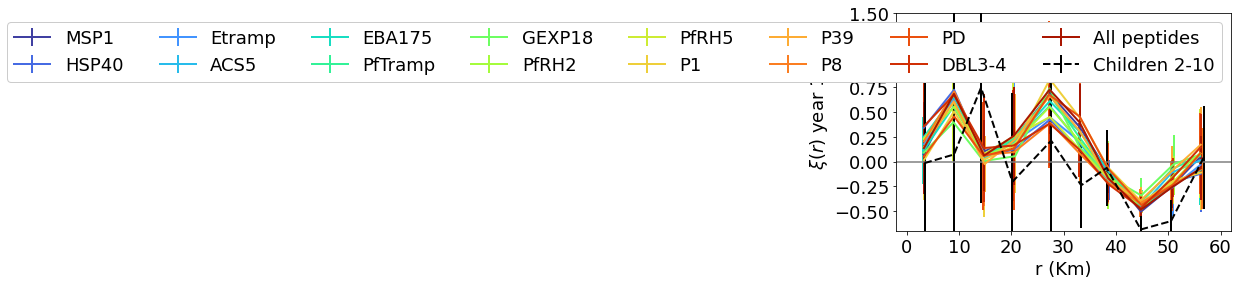

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs


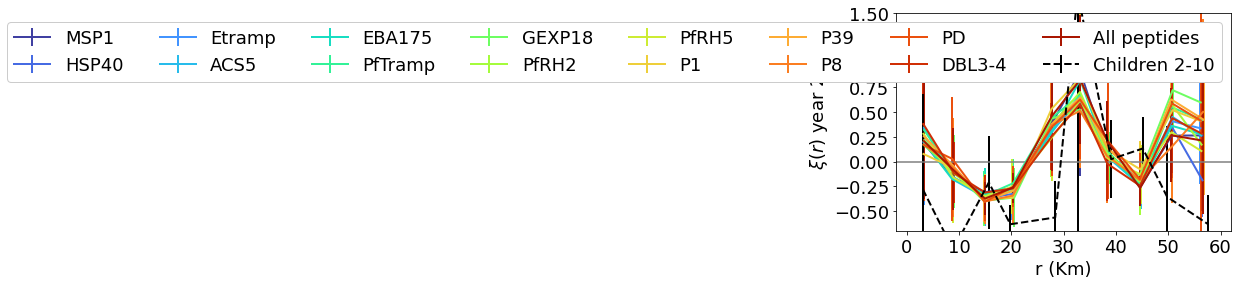

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs


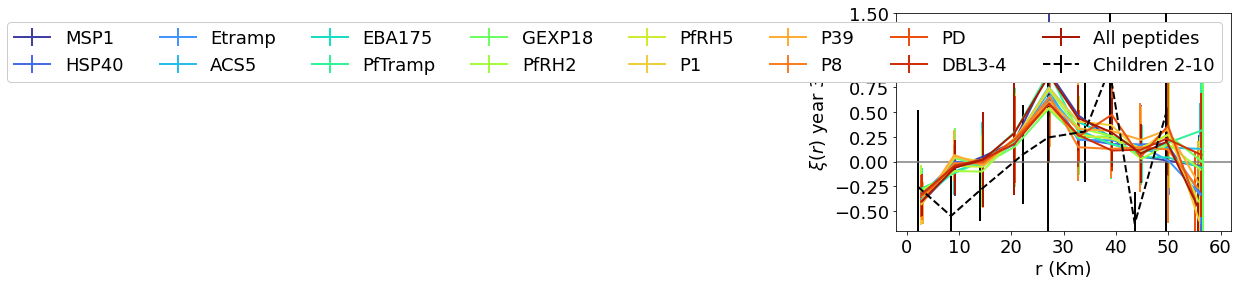

In [17]:
#Cross, large scales, cross-correlated with qPCR from children 2-10
cutoff = 'FMM_'
antigens_2pcf = antigens
antigens_2pcf = [cutoff + i for i in antigens_2pcf]


mip_2pcf_y_x, mean_bin_mip_y_x, edges_y_x, mip_err_y_x, cross_2pcf_x, mean_bin_cross_x, edges, cross_err_x = \
get_all_2pcf_years_sero_cross(mipmon, mip_pcrpos, antigens_2pcf, prenatal, cross210, cross210_pcrpos, \
                   has_pcr_cross210&cross210_area_mask, bins, ranges, nrands, colors_mipmon, 'k', figsize = None, \
                   mode = 'cross', ylims = [-.7,1.5], fontsize = 18, legend = True)



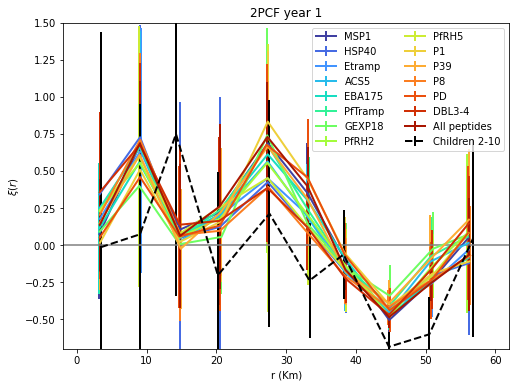

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs


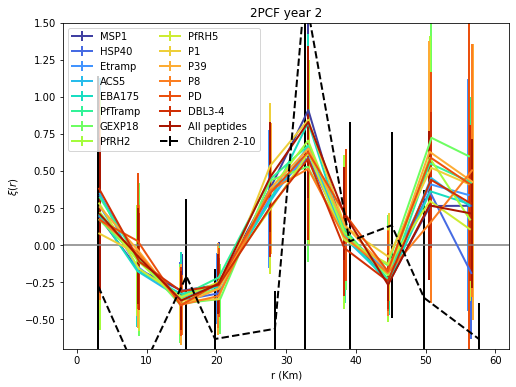

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs


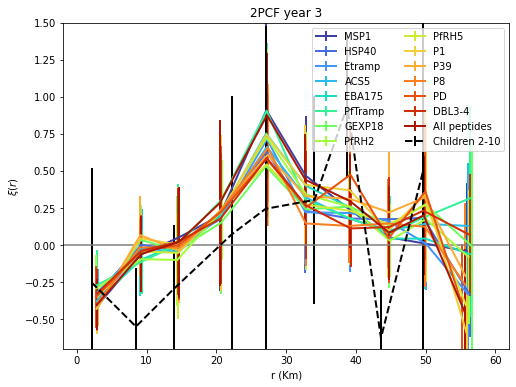

In [37]:
#Cross, large scales, cross-correlated with qPCR from children 2-10
cutoff = 'FMM_'
antigens_2pcf = antigens
antigens_2pcf = [cutoff + i for i in antigens_2pcf]


mip_2pcf_y_x, mean_bin_mip_y_x, edges_y_x, mip_err_y_x, cross_2pcf_x, mean_bin_cross_x, edges, cross_err_x = \
get_all_2pcf_years_sero_cross(mipmon, mip_pcrpos, antigens_2pcf, prenatal, cross210, cross210_pcrpos, \
                   has_pcr_cross210&cross210_area_mask, bins, ranges, nrands, colors_mipmon, 'k', figsize = [8, 6], \
                   mode = 'cross', ylims = [-.7,1.5])



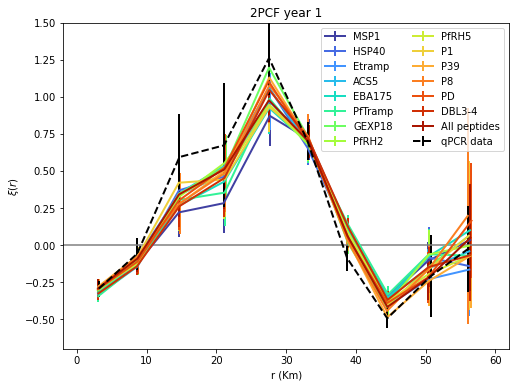

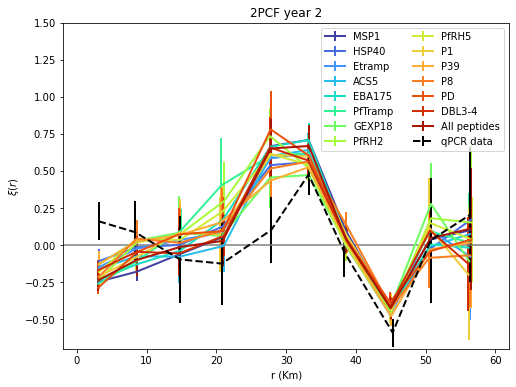

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs


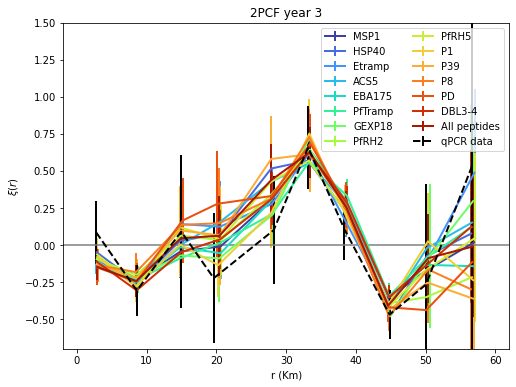

In [15]:
#Cross, large scales, cross-correlated with qPCR from pregnant women
cutoff = 'FMM_'
antigens_2pcf = antigens
antigens_2pcf = [cutoff + i for i in antigens_2pcf]


mip_2pcf_y_x, mean_bin_mip_y_x, edges_y_x, mip_err_y_x, cross_2pcf_x, mean_bin_cross_x, edges, cross_err_x = \
get_all_2pcf_years(mipmon, mip_pcrpos, antigens_2pcf, prenatal, mipmon, mip_pcrpos, \
                   mipmon_pn, bins, ranges, nrands, colors_mipmon, 'k', figsize = [8, 6], \
                   mode = 'cross', ylims = [-.7,1.5])

#### checking all parity and HIV selections

All ANC visits


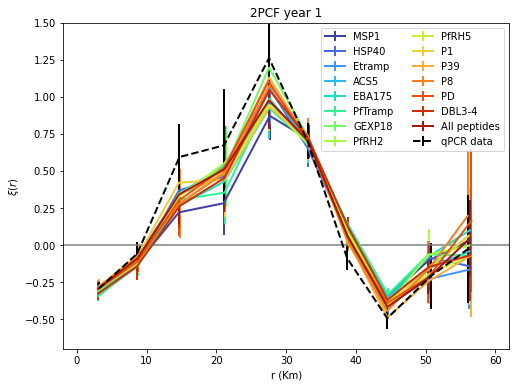

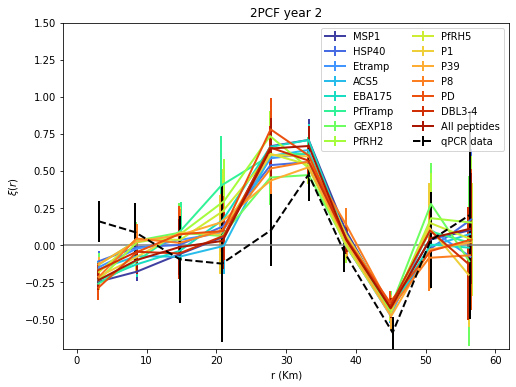

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs


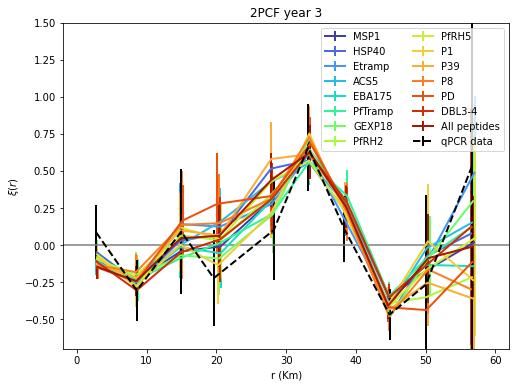

Primigravidae


/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clusterin

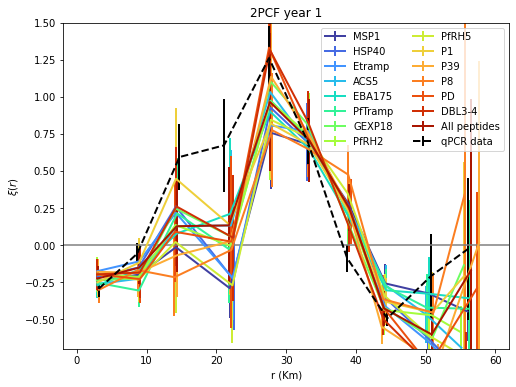

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clusterin

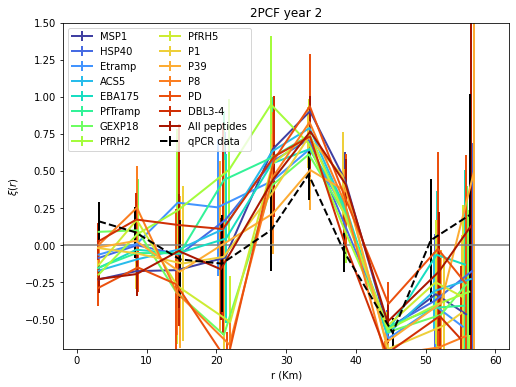

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clusterin

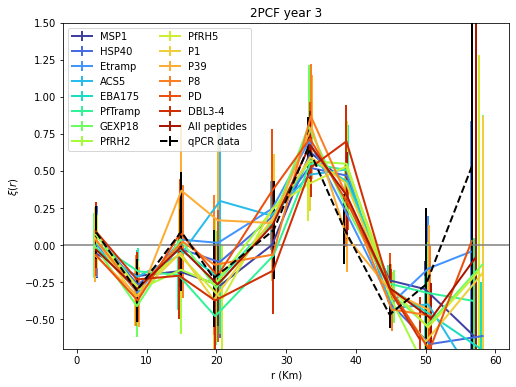

Multigravidae


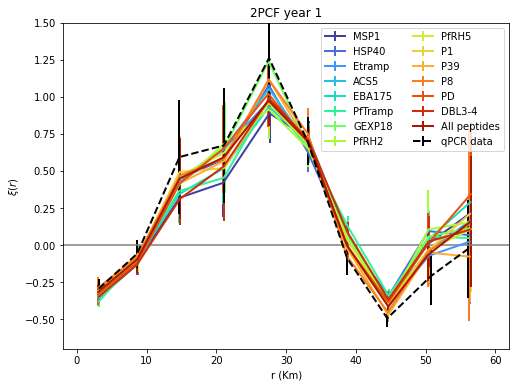

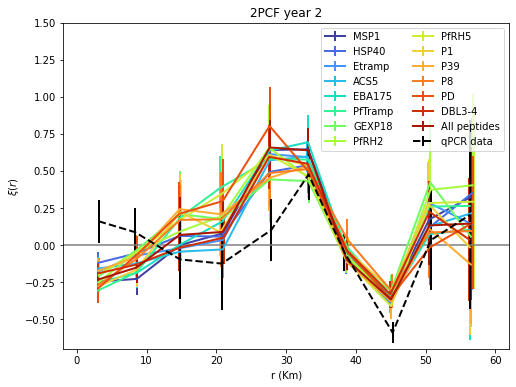

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs


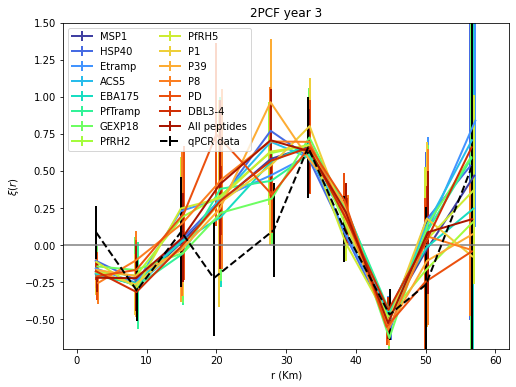

HIV+


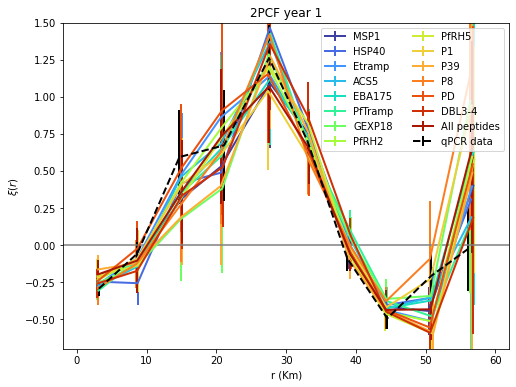

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clusterin

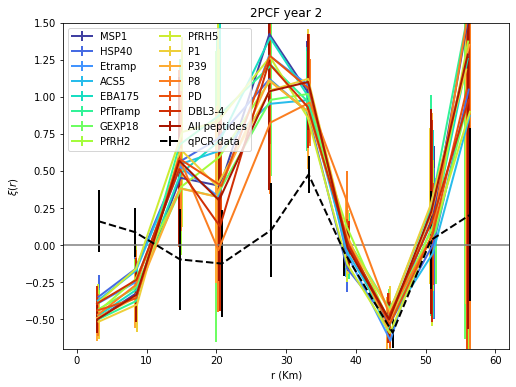

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clusterin

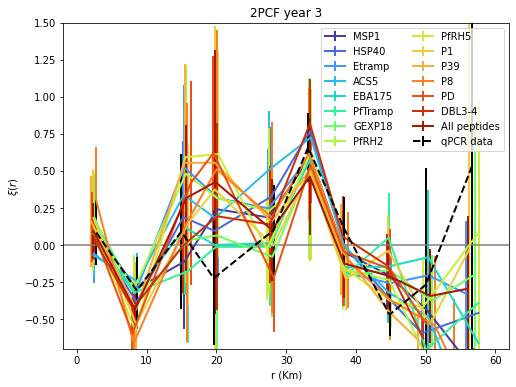

HIV-


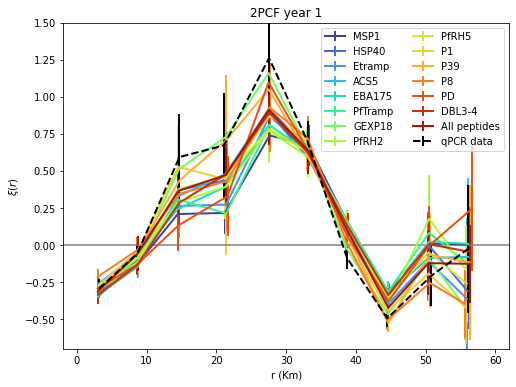

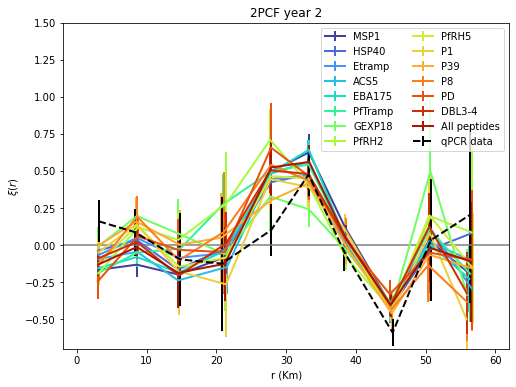

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clusterin

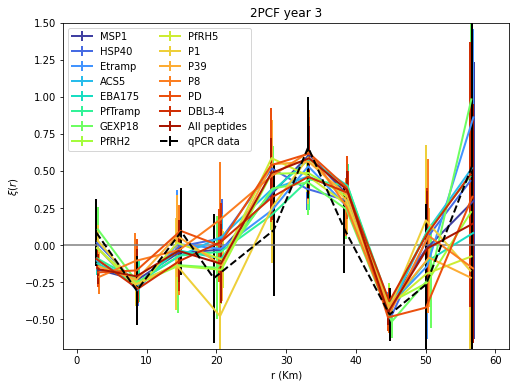

Primigravid HIV-


/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clusterin

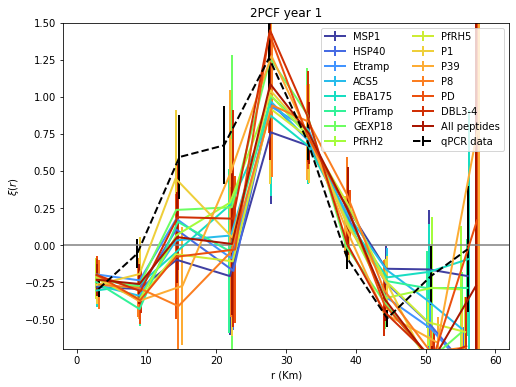

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clusterin

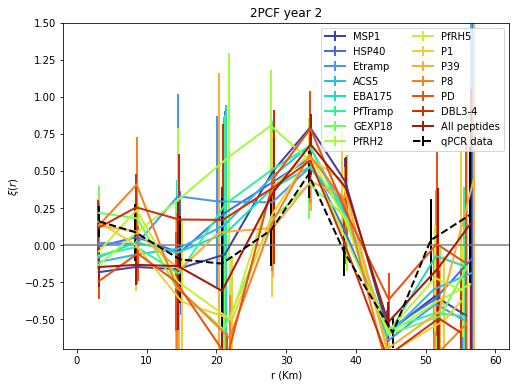

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
  weighted_bins /= numpairs
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clusterin

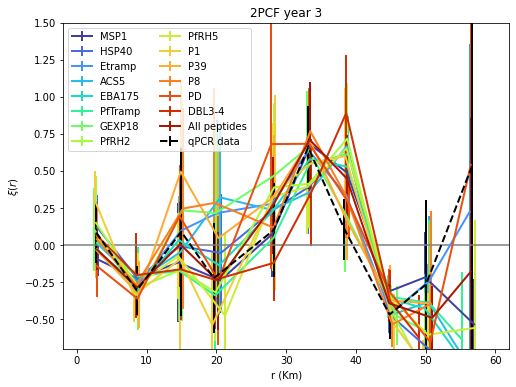

In [14]:
#Cross, large scales
cutoff = 'FMM_'
antigens_2pcf = antigens
antigens_2pcf = [cutoff + i for i in antigens_2pcf]


for selection in mipmon_selection:
    print(selection)
    mip_2pcf_y_x_sel, mean_bin_mip_y_x_sel, edges_y_x_sel, mip_err_y_x_sel, cross_2pcf_x_sel, mean_bin_cross_x_sel, edges_sel, cross_err_x_sel = \
    get_all_2pcf_years(mipmon, mip_pcrpos, antigens_2pcf, \
                       prenatal&mipmon_selection[selection], mipmon, mip_pcrpos, \
                   mipmon_pn, bins, ranges, nrands, colors_mipmon, 'k', figsize = [8, 6], \
                   mode = 'cross', ylims = [-.7,1.5])

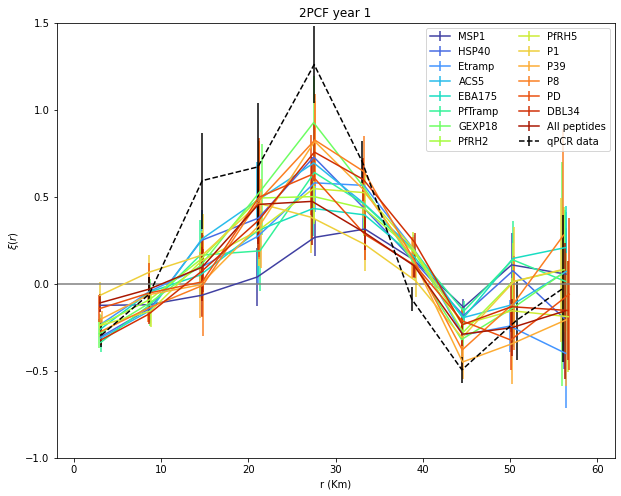

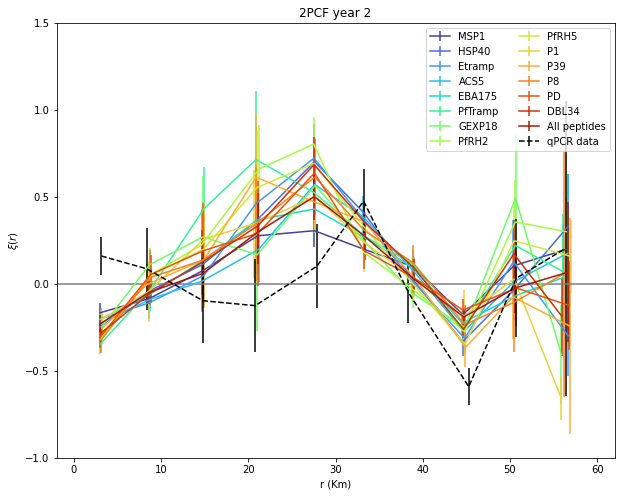

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide


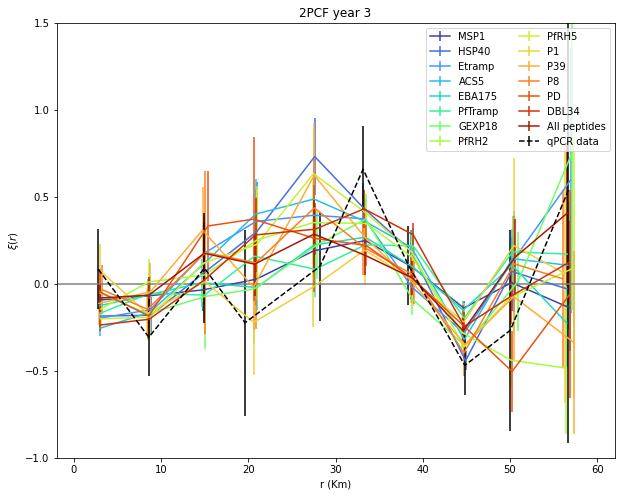

In [7]:
#Auto, large scales
cutoff = 'FMM_'
antigens_2pcf = antigens
antigens_2pcf = [cutoff + i for i in antigens_2pcf]


mip_2pcf_y, mean_bin_mip_y, edges_y, mip_err_y, cross_2pcf, mean_bin_cross, edges, cross_err = \
get_all_2pcf_years(mipmon, mip_pcrpos, antigens_2pcf, prenatal, mipmon, mip_pcrpos, \
                   mipmon_pn, bins, ranges, nrands, colors_mipmon, 'k', figsize = [10, 8], ylims = [-1,1.5])

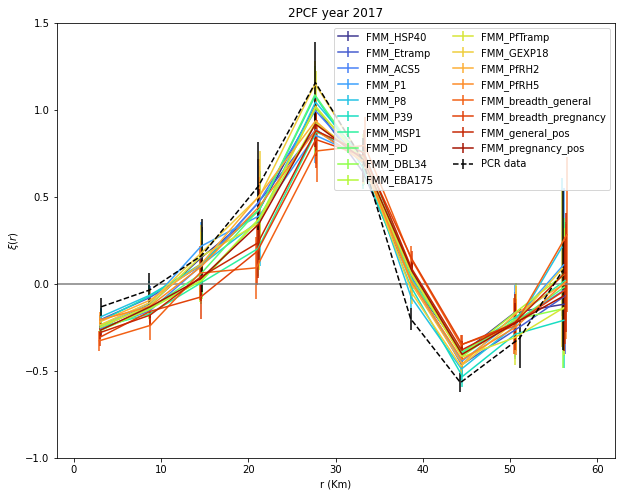

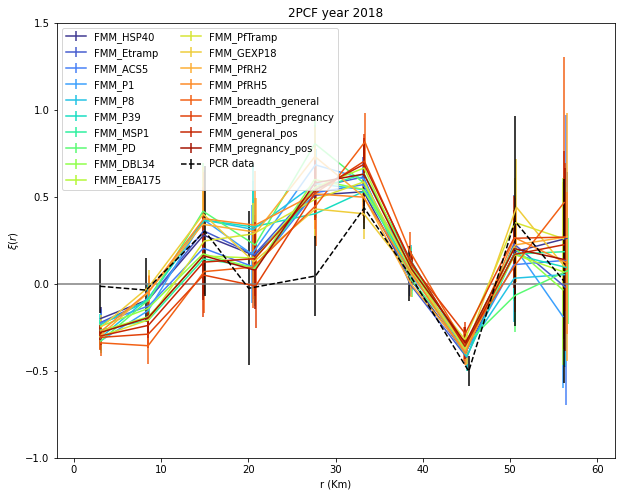

/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide
/home/isglobal.lan/apujol/anaconda3/envs/gen/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in true_divide


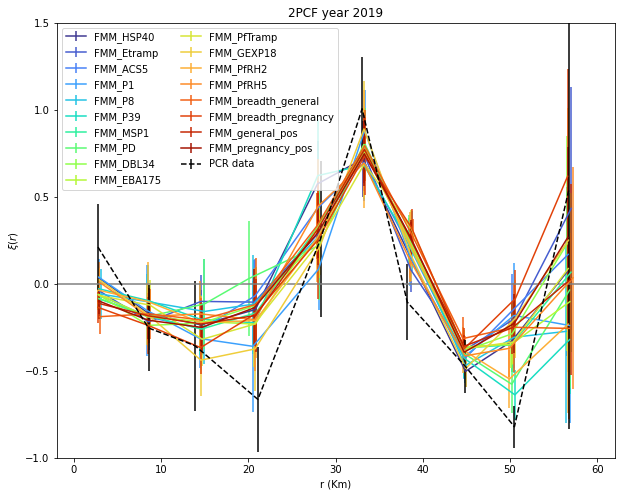

In [7]:
#Cross, large scales
cutoff = 'FMM_'
antigens_2pcf = antigens
antigens_2pcf = [cutoff + i for i in antigens_2pcf]


mip_2pcf_y_x, mean_bin_mip_y_x, edges_y_x, mip_err_y_x, cross_2pcf_x, mean_bin_cross_x, edges, cross_err_x = \
get_all_2pcf_years(mipmon, mip_pcrpos, antigens_2pcf, prenatal, mipmon, mip_pcrpos, \
                   mipmon_pn, bins, ranges, nrands, colors_mipmon, 'k', figsize = [10, 8], \
                   mode = 'cross', ylims = [-1,1.5])

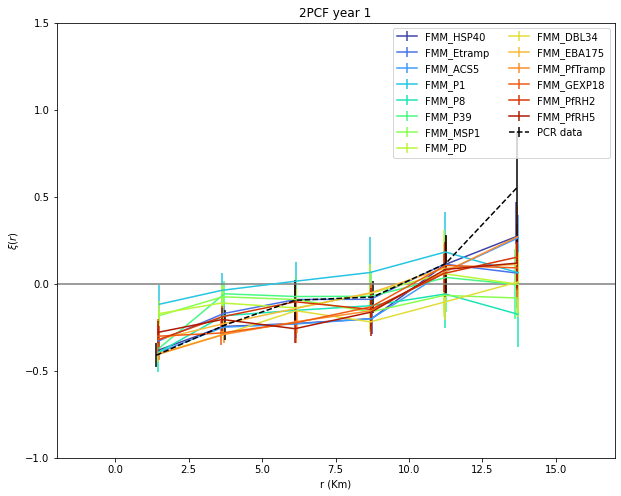

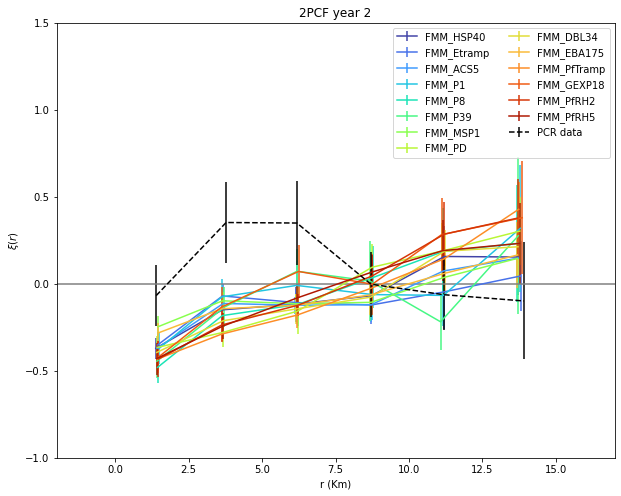

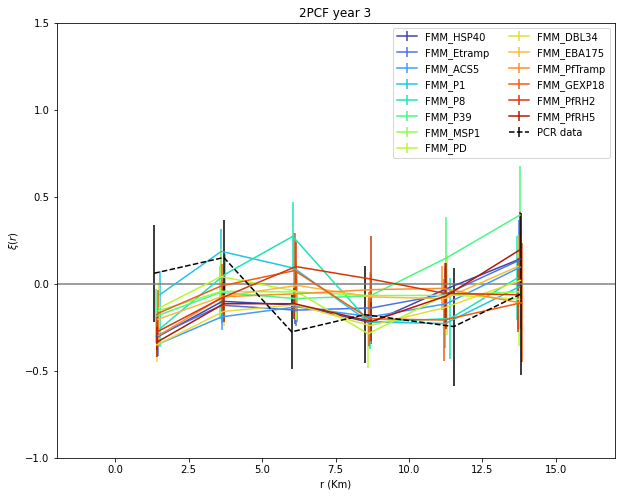

In [11]:
#Auto, small scales
cutoff = 'FMM_'
antigens_2pcf = antigens
antigens_2pcf = [cutoff + i for i in antigens_2pcf]


mip_2pcf_y, mean_bin_mip_y, edges_y, mip_err_y, cross_2pcf, mean_bin_cross, edges, cross_err = \
get_all_2pcf_years(mipmon, mip_pcrpos, antigens_2pcf, prenatal, mipmon, mip_pcrpos, \
                   mipmon_pn, bins_small_scale, range_small_scale, nrands, colors_mipmon, 'k', \
                   figsize = [10, 8], ylims = [-1,1.5])

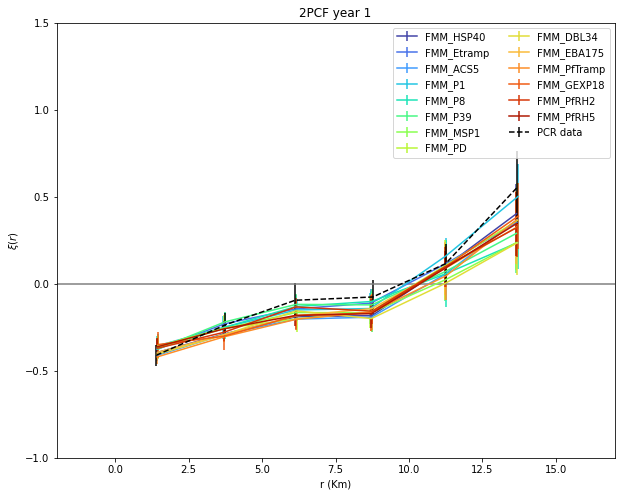

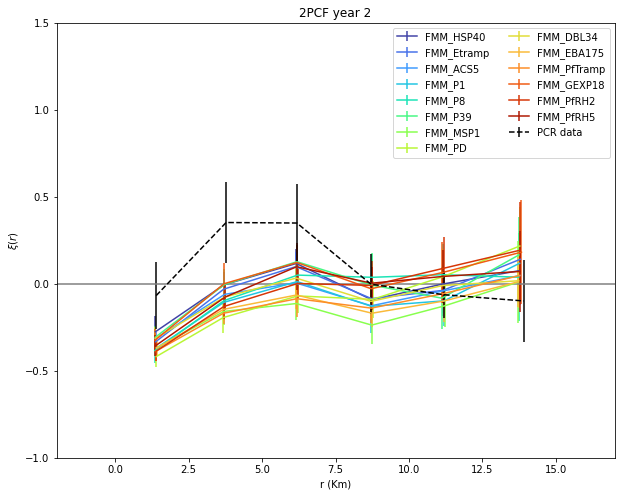

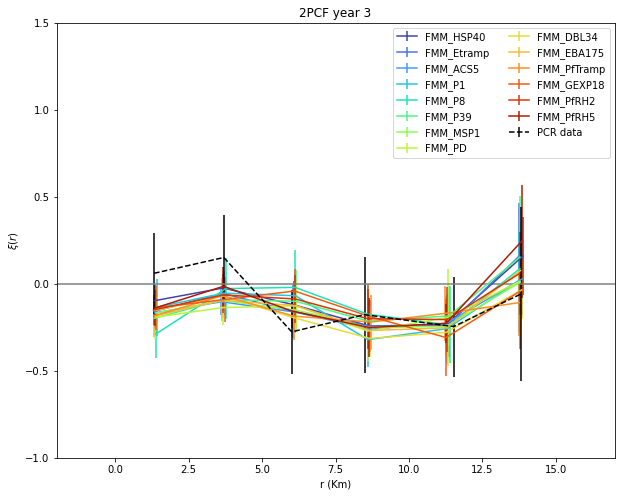

In [12]:
#Cross, small scales
cutoff = 'FMM_'
antigens_2pcf = antigens
antigens_2pcf = [cutoff + i for i in antigens_2pcf]


mip_2pcf_y_x_ss, mean_bin_mip_y_x_ss, edges_y_x_ss, mip_err_y_x_ss, cross_2pcf_x_ss, mean_bin_cross_x_ss, edges_x_ss, cross_err_x_ss = \
get_all_2pcf_years(mipmon, mip_pcrpos, antigens_2pcf, prenatal, mipmon, mip_pcrpos, \
                   mipmon_pn, bins_small_scale, range_small_scale, nrands, colors_mipmon, 'k', \
                   figsize = [10, 8], mode = 'cross', ylims = [-1,1.5])

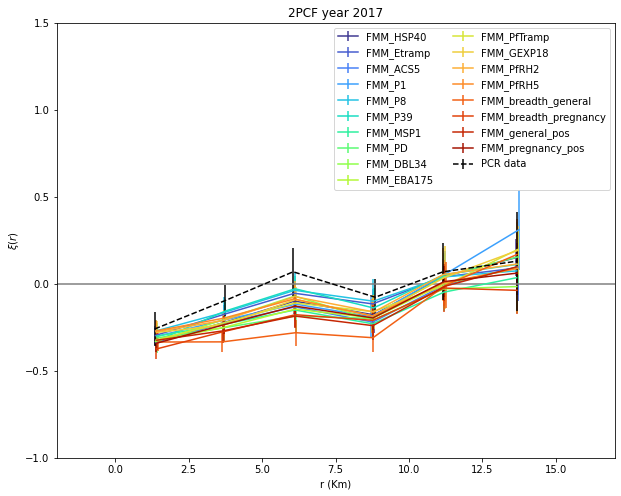

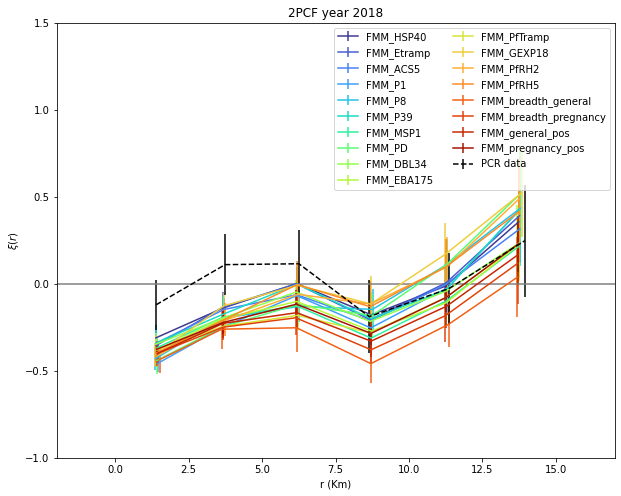

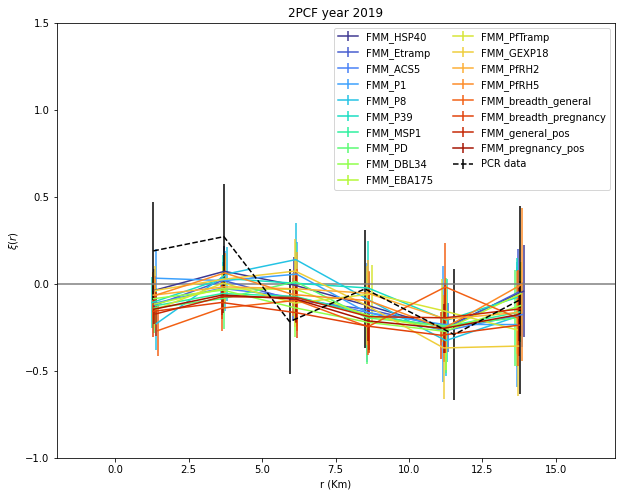

In [10]:
#Cross, small scales
cutoff = 'FMM_'
antigens_2pcf = antigens
antigens_2pcf = [cutoff + i for i in antigens_2pcf]


mip_2pcf_y_x_ss, mean_bin_mip_y_x_ss, edges_y_x_ss, mip_err_y_x_ss, cross_2pcf_x_ss, mean_bin_cross_x_ss, edges_x_ss, cross_err_x_ss = \
get_all_2pcf_years(mipmon, mip_pcrpos, antigens_2pcf, prenatal, mipmon, mip_pcrpos, \
                   mipmon_pn, bins_small_scale, range_small_scale, nrands, colors_mipmon, 'k', \
                   figsize = [10, 8], mode = 'cross', ylims = [-1,1.5])

## Testing very small scales 

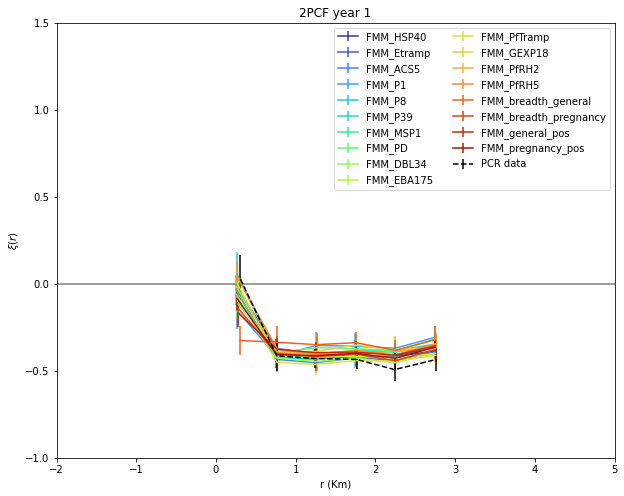

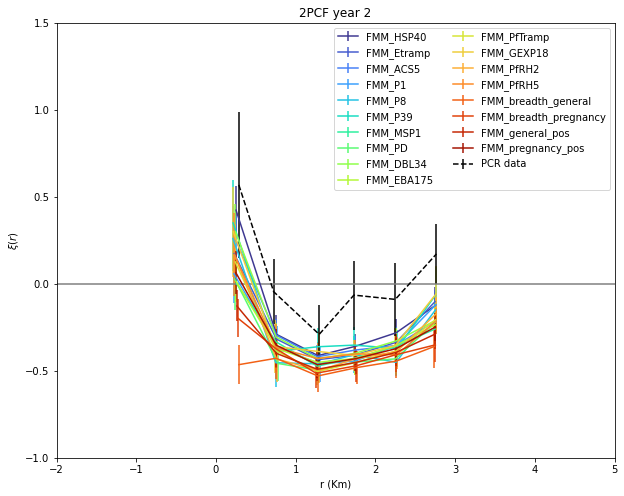

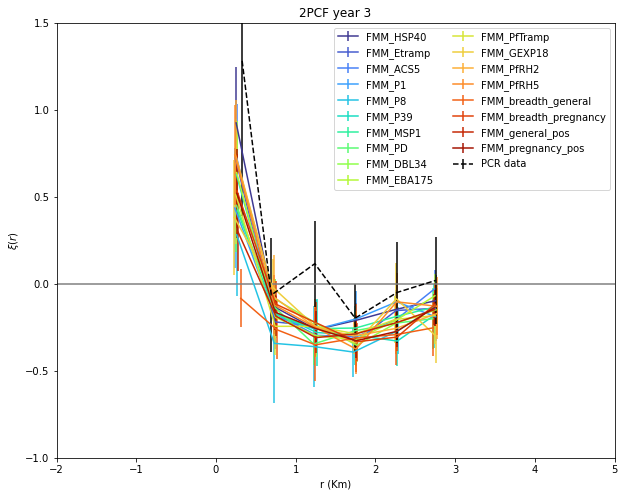

In [34]:
#Cross, small scales
cutoff = 'FMM_'
antigens_2pcf = antigens
antigens_2pcf = [cutoff + i for i in antigens_2pcf]


mip_2pcf_y_x_ss, mean_bin_mip_y_x_ss, edges_y_x_ss, mip_err_y_x_ss, cross_2pcf_x_ss, mean_bin_cross_x_ss, edges_x_ss, cross_err_x_ss = \
get_all_2pcf_years(mipmon, mip_pcrpos, antigens_2pcf, prenatal, mipmon, mip_pcrpos, \
                   mipmon_pn, bins_small_scale, [0,3], nrands, colors_mipmon, 'k', \
                   figsize = [10, 8], mode = 'cross', ylims = [-1,1.5])

### Consistency analysis:

$\chi²$ Statistics will be obtained comparing the 2PCF measurement in children with the different populations of pregnant women. Values larger than a chi2 threshold will be considered as different results between the two populations. Alternatively, t-test statistics will be used for the same purpose (they should give the same conclusions).

In [11]:
chi2_y_x_ss = {}
for y in years:
    chi2_y_x_ss[str(y)] = {}
    for s in antigens_2pcf:
        mask = (cross_err_x_ss[str(y)]**2 > 0)&(mip_err_y_x_ss[str(y)][s]**2 > 0)
        chi2_y_x_ss[str(y)][s] = errors.chi_square(cross_2pcf_x_ss[str(y)][mask], cross_err_x_ss[str(y)][mask], mip_2pcf_y_x_ss[str(y)][s][mask], mip_err_y_x_ss[str(y)][s][mask])
chi2_y_x_ss = pd.DataFrame(chi2_y_x_ss)

In [10]:
chi2_y = {}
for y in years:
    chi2_y[str(y)] = {}
    for s in antigens_2pcf:
        mask = (cross_err[str(y)]**2 > 0)&(mip_err_y[str(y)][s]**2 > 0)
        chi2_y[str(y)][s] = errors.chi_square(cross_2pcf[str(y)][mask], cross_err[str(y)][mask], mip_2pcf_y[str(y)][s][mask], mip_err_y[str(y)][s][mask])
chi2_y = pd.DataFrame(chi2_y)

In [38]:
chi2_y_x = {}
for y in years:
    chi2_y_x[str(y)] = {}
    for s in antigens_2pcf:
        mask = (cross_err_x[str(y)]**2 > 0)&(mip_err_y_x[str(y)][s]**2 > 0)
        chi2_y_x[str(y)][s] = errors.chi_square(cross_2pcf_x[str(y)][mask], cross_err_x[str(y)][mask], mip_2pcf_y_x[str(y)][s][mask], mip_err_y_x[str(y)][s][mask])
chi2_y_x = pd.DataFrame(chi2_y_x)

In [92]:


chi2_tw90 = {}
for y in years:
    chi2_tw90[str(y)] = {}
    for s in antigens_2pcf:
        mask = (cross_err[str(y)]**2 > 0)&(mip_err_tw90[str(y)][s]**2 > 0)
        chi2_tw90[str(y)][s] = errors.chi_square(cross_2pcf[str(y)][mask], cross_err[str(y)][mask], mip_2pcf_tw90[str(y)][s][mask], mip_err_tw90[str(y)][s][mask])
chi2_tw90 = pd.DataFrame(chi2_tw90)

chi2_tw180 = {}
for y in years:
    chi2_tw180[str(y)] = {}
    for s in antigens_2pcf:
        mask = (cross_err[str(y)]**2 > 0)&(mip_err_tw180[str(y)][s]**2 > 0)
        chi2_tw180[str(y)][s] = errors.chi_square(cross_2pcf[str(y)][mask], cross_err[str(y)][mask], mip_2pcf_tw180[str(y)][s][mask], mip_err_tw180[str(y)][s][mask])
chi2_tw180 = pd.DataFrame(chi2_tw180)

In [13]:
chi2_y_x_ss

2017      2018      2019
FMM_HSP40              0.617326  0.588567  0.225221
FMM_Etramp             0.247507  0.660249  0.330605
FMM_ACS5               0.855822  0.782967  0.375523
FMM_P1                 0.616820  1.551064  0.250833
FMM_P8                 0.124282  1.336222  0.515439
FMM_P39                0.211971  0.666642  0.304344
FMM_MSP1               0.985765  1.132013  0.430769
FMM_PD                 0.866762  1.513362  0.445497
FMM_DBL34              0.648668  0.885770  0.352030
FMM_EBA175             0.961479  1.180973  0.401920
FMM_PfTramp            0.659601  1.363438  0.381217
FMM_GEXP18             0.551834  1.021342  0.335007
FMM_PfRH2              0.399036  1.286586  0.305521
FMM_PfRH5              0.434307  1.070452  0.235500
FMM_breadth_general    2.261921  1.925675  0.748197
FMM_breadth_pregnancy  1.298615  1.650634  0.508884
FMM_general_pos        1.201824  1.424316  0.489502
FMM_pregnancy_pos      0.849209  1.259862  0.476373

In [11]:
chi2_y

1         2         3
FMM_MSP1          6.036655  2.680843  0.845769
FMM_HSP40         2.453963  2.200289  0.622600
FMM_Etramp        2.138330  2.110057  0.650316
FMM_ACS5          3.103130  2.223857  0.746142
FMM_EBA175        3.852498  2.448868  0.820447
FMM_PfTramp       3.260055  3.335914  0.825423
FMM_GEXP18        0.910828  1.987756  0.303269
FMM_PfRH2         2.517050  3.341172  0.629723
FMM_PfRH5         2.223176  2.833774  0.534636
FMM_P1            2.610827  2.071783  0.463263
FMM_P39           1.101044  1.640598  0.595430
FMM_P8            0.852407  2.429732  0.438118
FMM_PD            2.480631  3.433210  0.575118
FMM_DBL34         3.048790  3.013195  0.615488
FMM_All peptides  2.802241  2.848875  0.711872

In [39]:
##Cross-correlating qPCR in children with serology
chi2_y_x

1         2         3
FMM_MSP1          0.555080  1.071775  0.819688
FMM_HSP40         0.533193  1.123661  0.843518
FMM_Etramp        0.589683  0.937998  0.598438
FMM_ACS5          0.602481  1.161505  0.750550
FMM_EBA175        0.567920  1.092615  0.596072
FMM_PfTramp       0.726873  1.276220  0.723373
FMM_GEXP18        0.643331  0.799362  0.572267
FMM_PfRH2         0.564394  1.203052  0.614468
FMM_PfRH5         0.530310  0.895532  0.633566
FMM_P1            0.801549  1.600201  0.634146
FMM_P39           0.669031  0.914653  0.647872
FMM_P8            0.571854  1.453652  0.810168
FMM_PD            0.539989  1.170260  0.498239
FMM_DBL3-4        0.587531  1.385305  0.723169
FMM_All peptides  0.755035  1.524441  0.600882

In [12]:
#Cross-correlating qPCR in PW with serology
chi2_y_x

1         2         3
FMM_MSP1          1.147785  1.845886  0.258695
FMM_HSP40         0.800369  0.768313  0.236146
FMM_Etramp        0.478014  1.013597  0.181887
FMM_ACS5          0.875488  1.264138  0.322036
FMM_EBA175        1.071962  1.697289  0.280365
FMM_PfTramp       1.320040  1.873022  0.277889
FMM_GEXP18        0.299210  0.778121  0.133239
FMM_PfRH2         0.609557  1.541009  0.221303
FMM_PfRH5         0.651289  1.120724  0.186775
FMM_P1            0.433846  1.401750  0.161832
FMM_P39           0.254634  0.654239  0.337509
FMM_P8            0.319227  1.203287  0.259176
FMM_PD            0.415064  2.082208  0.331073
FMM_DBL34         0.856505  1.375338  0.258385
FMM_All peptides  0.414376  1.491955  0.314029

###  Significance analysis:

A t-test will be used to measure the statistical significance of the clustering signal of the different populations by measuring the deviation of the 2PCFs from zero. A table will be created describing the p-values of each population and year to identify the most significant clustering structures found.

In [40]:
import scipy.stats as sci_stats

In [41]:
def chi22p(chi2, dof):
    """This method translates from chi square statistics
    to p-value to get statistical significancy.
    
    Parameters:
    -----------
    chi2: float
        Value of chi square
    dof: int
        Number of degrees of freedom
    
    Returns:
    --------
    p: float
        P-value of statistical significance of the difference
    """
    p = 1 - sci_stats.chi2.cdf(chi2, dof)
    return p

In [42]:
sig_cross_x = {}
p_cross_x = {}
for y in years:
    sig_cross_x[str(y)] = {}
    p_cross_x[str(y)] = {}
    mask = cross_err_x[str(y)]**2 > 0
    sig_cross_x[str(y)]['qPCR data'] = errors.chi_square(cross_2pcf_x[str(y)][mask], cross_err_x[str(y)][mask], \
                                                           0*cross_2pcf_x[str(y)][mask], 0*cross_err_x[str(y)][mask])
    p_cross_x[str(y)]['qPCR data'] = chi22p(sig_cross_x[str(y)]['qPCR data']*bins, bins)
sig_cross_x = pd.DataFrame(sig_cross_x)
p_cross_x = pd.DataFrame(p_cross_x)


In [43]:
sig_cross_x

1          2         3
qPCR data  5.592599  25.429074  1.143911

In [44]:
p_cross_x

1    2         3
qPCR data  2.119490e-08  0.0  0.324346

In [45]:
sig_y_x = {}
p_y_x = {}
for y in years:
    sig_y_x[str(y)] = {}
    p_y_x[str(y)] = {}
    for s in antigens_2pcf:
        mask = mip_err_y_x[str(y)][s]**2 > 0
        sig_y_x[str(y)][s] = errors.chi_square(mip_2pcf_y_x[str(y)][s][mask], mip_err_y_x[str(y)][s][mask], \
                                             0*mip_2pcf_y_x[str(y)][s][mask], 0*mip_err_y_x[str(y)][s][mask])
        p_y_x[str(y)][s] = chi22p(sig_y_x[str(y)][s]*bins, bins)
sig_y_x = pd.DataFrame(sig_y_x)
p_y_x = pd.DataFrame(p_y_x)

In [46]:
sig_y_x

1         2         3
FMM_MSP1          3.712975  0.675727  1.301664
FMM_HSP40         1.472105  0.685152  0.834637
FMM_Etramp        2.487794  0.772135  0.830864
FMM_ACS5          1.652749  0.898867  1.020199
FMM_EBA175        3.186284  0.804308  0.977139
FMM_PfTramp       1.419298  0.999291  0.801402
FMM_GEXP18        0.518533  0.724796  1.067721
FMM_PfRH2         2.738839  0.795682  0.600179
FMM_PfRH5         1.450459  0.588834  0.962723
FMM_P1            2.026385  1.740544  1.580274
FMM_P39           1.200220  0.708159  1.504733
FMM_P8            1.837782  1.035137  0.937237
FMM_PD            1.353016  0.969909  0.887677
FMM_DBL3-4        3.690601  1.071592  0.754823
FMM_All peptides  6.146131  1.659077  1.444152

In [23]:
p_y_x

1             2             3
FMM_MSP1          0.0  0.000000e+00  1.367316e-09
FMM_HSP40         0.0  3.774758e-15  4.056755e-13
FMM_Etramp        0.0  2.109424e-15  4.747235e-06
FMM_ACS5          0.0  0.000000e+00  0.000000e+00
FMM_EBA175        0.0  0.000000e+00  1.120372e-08
FMM_PfTramp       0.0  0.000000e+00  3.321240e-10
FMM_GEXP18        0.0  4.821988e-08  1.056571e-06
FMM_PfRH2         0.0  0.000000e+00  1.021490e-08
FMM_PfRH5         0.0  0.000000e+00  9.609626e-08
FMM_P1            0.0  1.521006e-14  1.509115e-05
FMM_P39           0.0  9.547918e-15  1.528183e-08
FMM_P8            0.0  1.665335e-15  4.419822e-07
FMM_PD            0.0  0.000000e+00  2.525757e-13
FMM_DBL34         0.0  0.000000e+00  5.255218e-11
FMM_All peptides  0.0  1.665335e-15  1.384215e-11

In [20]:
sig_y = {}
p_y = {}
for y in years:
    sig_y[str(y)] = {}
    p_y[str(y)] = {}
    for s in antigens_2pcf:
        mask = mip_err_y[str(y)][s]**2 > 0
        sig_y[str(y)][s] = errors.chi_square(mip_2pcf_y[str(y)][s][mask], mip_err_y[str(y)][s][mask], \
                                             0*mip_2pcf_y[str(y)][s][mask], 0*mip_err_y[str(y)][s][mask])
        p_y[str(y)][s] = chi22p(sig_y[str(y)][s]*bins, bins)
sig_y = pd.DataFrame(sig_y)
p_y = pd.DataFrame(p_y)

In [22]:
sig_y

1          2          3
FMM_MSP1           5.237890   6.455353   3.161858
FMM_HSP40         11.695172   9.756398  10.446566
FMM_Etramp         7.930108   7.505510   5.734617
FMM_ACS5          12.383121   7.363608   9.752771
FMM_EBA175        10.034952   6.330133   3.940381
FMM_PfTramp        8.682014   8.161961   2.439384
FMM_GEXP18         5.306710   3.373376   2.118884
FMM_PfRH2          9.025663   7.246089   3.770762
FMM_PfRH5          5.617187  12.081205   5.803862
FMM_P1             2.734041   5.694270   0.754448
FMM_P39            7.228395   4.870282   1.908660
FMM_P8             5.076344   4.146769   1.418564
FMM_PD             2.975263   5.574942   1.680709
FMM_DBL34         20.511024  10.386021  10.887024
FMM_All peptides   4.456888   6.882080   2.181632

In [24]:
p_y

1             2             3
FMM_MSP1          9.708369e-08  4.933737e-10  4.634345e-04
FMM_HSP40         0.000000e+00  2.220446e-16  0.000000e+00
FMM_Etramp        6.881162e-13  4.641731e-12  1.147530e-08
FMM_ACS5          0.000000e+00  8.761880e-12  2.220446e-16
FMM_EBA175        0.000000e+00  8.554379e-10  2.156985e-05
FMM_PfTramp       2.287059e-14  2.414735e-13  6.620905e-03
FMM_GEXP18        7.235335e-08  2.048865e-04  1.981457e-02
FMM_PfRH2         4.773959e-15  1.481304e-11  4.266593e-05
FMM_PfRH5         1.906201e-08  0.000000e+00  8.501208e-09
FMM_P1            2.300019e-03  1.366369e-08  6.732345e-01
FMM_P39           1.603029e-11  4.617104e-07  3.917647e-02
FMM_P8            1.931004e-07  9.323374e-06  1.646913e-01
FMM_PD            9.401797e-04  2.287119e-08  7.874312e-02
FMM_DBL34         0.000000e+00  0.000000e+00  0.000000e+00
FMM_All peptides  2.600802e-06  7.485446e-11  1.606815e-02

In [16]:
sig_cross_x_ss = {}
for y in years:
    sig_cross_x_ss[str(y)] = {}
    mask = cross_err_x_ss[str(y)]**2 > 0
    sig_cross_x_ss[str(y)]['qPCR data'] = errors.chi_square(cross_2pcf_x_ss[str(y)][mask], cross_err_x_ss[str(y)][mask], \
                                                           0*cross_2pcf_x_ss[str(y)][mask], 0*cross_err_x_ss[str(y)][mask])
sig_cross_x_ss = pd.DataFrame(sig_cross_x_ss)

sig_y_x_ss = {}
for y in years:
    sig_y_x_ss[str(y)] = {}
    for s in antigens_2pcf:
        mask = mip_err_y_x_ss[str(y)][s]**2 > 0
        sig_y_x_ss[str(y)][s] = errors.chi_square(mip_2pcf_y_x_ss[str(y)][s][mask], mip_err_y_x_ss[str(y)][s][mask], \
                                             0*mip_2pcf_y_x_ss[str(y)][s][mask], 0*mip_err_y_x_ss[str(y)][s][mask])
sig_y_x_ss = pd.DataFrame(sig_y_x_ss)

In [96]:


sig_tw90 = {}
for y in years:
    sig_tw90[str(y)] = {}
    for s in mipmon_selection:
        mask = mip_err_tw90[str(y)][s]**2 > 0
        sig_tw90[str(y)][s] = errors.chi_square(mip_2pcf_tw90[str(y)][s][mask], mip_err_tw90[str(y)][s][mask], \
                                                0*mip_2pcf_tw90[str(y)][s][mask], 0*mip_err_tw90[str(y)][s][mask])
sig_tw90 = pd.DataFrame(sig_tw90)

sig_tw180 = {}
for y in years:
    sig_tw180[str(y)] = {}
    for s in mipmon_selection:
        mask = mip_err_tw180[str(y)][s]**2 > 0
        sig_tw180[str(y)][s] = errors.chi_square(mip_2pcf_tw180[str(y)][s][mask], mip_err_tw180[str(y)][s][mask], \
                                                 0*mip_2pcf_tw180[str(y)][s][mask], 0*mip_err_tw180[str(y)][s][mask])
sig_tw180 = pd.DataFrame(sig_tw180)

In [18]:
sig_cross_x_ss

2017      2018      2019
PCR data  1.62627  0.479907  0.400513

In [19]:
sig_y_x

2017       2018      2019
FMM_HSP40              28.658923   9.790054  5.783828
FMM_Etramp             16.528134   8.910164  6.227169
FMM_ACS5               27.683807  12.879714  5.247348
FMM_P1                 20.904326   8.981677  3.216723
FMM_P8                 14.771343   7.932473  5.065093
FMM_P39                16.333255   7.038036  5.821448
FMM_MSP1               28.934786  12.497351  6.744589
FMM_PD                 18.464430  11.983471  5.710938
FMM_DBL34              21.294583  15.426659  5.098190
FMM_EBA175             14.815111  11.652142  7.683247
FMM_PfTramp            20.445430   8.869864  6.079023
FMM_GEXP18             25.617284   4.760870  4.214870
FMM_PfRH2              29.833111   9.187093  3.025919
FMM_PfRH5              17.268569  10.507585  4.398399
FMM_breadth_general    12.514575   7.623827  4.108530
FMM_breadth_pregnancy  17.542736   9.068576  4.254004
FMM_general_pos        19.076520  15.004867  6.482854
FMM_pregnancy_pos      26.593291   9.875825  6.300368

In [20]:
sig_y_x_ss

2017       2018      2019
FMM_HSP40              11.827353   4.822153  0.485166
FMM_Etramp              7.211466   4.231210  1.085356
FMM_ACS5               14.726283   8.574021  1.027689
FMM_P1                  9.988830  16.473540  0.229914
FMM_P8                  3.934196   8.653884  1.010818
FMM_P39                 7.271792   3.164123  0.248561
FMM_MSP1               10.771431  10.487677  1.291229
FMM_PD                  6.234403   8.695387  0.499746
FMM_DBL34              13.094935   8.771972  1.152569
FMM_EBA175             22.045269  26.414528  0.665081
FMM_PfTramp            12.926686   8.600004  0.869925
FMM_GEXP18              6.900286   7.828407  0.623054
FMM_PfRH2               6.816615   9.842483  0.316989
FMM_PfRH5               7.670545   9.709194  0.505727
FMM_breadth_general    17.682079  10.046781  1.266199
FMM_breadth_pregnancy  13.512006  12.259524  2.164643
FMM_general_pos        11.068814  11.648889  0.899587
FMM_pregnancy_pos      12.697863  20.156254  1.958144